# NLP_GoingDeeper | 16. HuggingFace 커스텀 프로젝트 만들기

NLP framework에서 가장 대표적인 Huggingface transformers를 활용하여 자신만의 커스텀 프로젝트를 만들어 보도록 할 것입니다.

다만, **Huggingface transformers의 구조 분석만으로는 실제로 활용 가능한 자신만의 무기가 되지 못합니다.**

이번 노드에서는 실전 프로젝트를 가정하고 Huggingface transformers framework를 활용하여 빠르게 자신만의 커스텀 프로젝트를 구성해 보는 실습을 진행하게 됩니다. framework 내의 Model, Tokenizer, Processor 등이 어떻게 활용되는지 꼼꼼히 살펴보고, 하나의 framework에 익숙해진다면 다른 framework에 적응하는 것도 훨씬 수월해질 것입니다.

## 1. GLUE Benchmark Dataset

Pretrained model의 성능을 측정하기 위해 최근은 SQuAD 등 기존에 유명한 데이터셋 한 가지만 가지고 성능을 논하는 것이 아니라, classification, summarization, reasoning, Q&A 등 NLP 모델의 성능을 평가할 수 있는 다양한 task를 해당 모델 하나만을 이용해 모두 수행해 보면서 종합적인 성능을 논하는 것이 일반화되었습니다.

그중 NLP 모델의 성능을 측정하기 위한 데이터셋으로 최근 활용되는 대표적인 것 중에 **General Language Understanding Evaluation(GLUE) benchmark Dataset이 있습니다. 총 10가지 데이터셋이 있습니다.** 각각의 개요는 다음과 같습니다.

관련 링크는 아래에 있습니다.

**아래 10가지의 task에 대하여 : https://gluebenchmark.com/tasks**

**리더보드 : https://gluebenchmark.com/leaderboard**

- CoLA : 문법에 맞는 문장인지 판단
- MNLI : 두 문장의 관계 판단(entailment, contradiction, neutral)
- MNLI-MM : 두 문장이 안 맞는지 판단
- MRPC : 두 문장의 유사도 평가
- SST-2 : 감정분석
- STS-B : 두 문장의 유사도 평가
- QQP : 두 질문의 유사도 평가
- QNLI : 질문과 paragraph 내 한 문장이 함의 관계(entailment)인지 판단
- RTE : 두 문장의 관계 판단(entailment, not_entailment)
- WNLI : 원문장과 대명사로 치환한 문장 사이의 함의 관계 판단

최근에는 한 가지 task에만 최적화된 모델이 아니라, **다양한 형태의 문제를 골고루 잘 푸는 모델**을 찾기 위한 노력이 계속되고 있습니다.

## 2. Huggingface가 제공하는 GLUE task 예제 코드

**Huggingface와 같은 NLP framework는 해당 framework를 활용하여 새로 만들어진 모델의 성능을 빠르게 평가해 볼 수 있도록 하는 예제 코드를 제공하고 있습니다.** 이런 예제 코드가 없다면 모델을 새로 만들 때마다 그 성능을 비교 측정해 보기 위한 작업이 너무나 번거롭게 될 것입니다.

우선, Huggingface의 예제 코드를 들여다보는 것으로부터 시작 하겠습니다.

**아래 명령어를 Cloud Shell에서 입력해 설치를 반드시 수행해야 이후의 진행에 문제가 없으니, 꼭 설치해야 합니다! 👍**

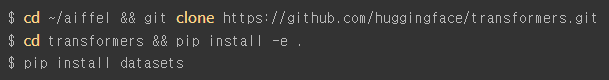

설치가 완료되었다면 아래 코드를 터미널에서 수행해 보겠습니다.

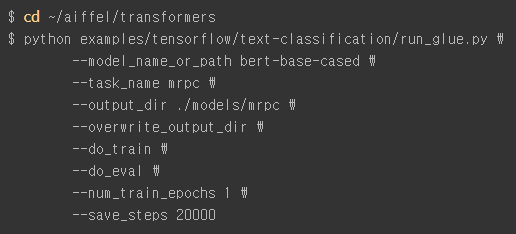

수행 결과는 아래와 같습니다.

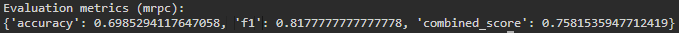

위 코드는 10가지 GLUE task 중 'mrpc' task를 수행하는 예제 코드입니다.

이 코드는 **Huggingface의 framework 기반으로 BERT bert-base-cased을 활용하여 'mrpc' task를 수행**합니다.

만약 task_name 및 다른 파라미터를 적절히 변경한 후 수행하면 다른 GLUE task도 간단히 수행해 볼 수 있을 것입니다.

model도 다양하게 바꾸어 보면서 수월하게 수행 가능할 것입니다.

이 예제만으로도 NLP framework의 강력함을 손쉽게 느껴볼 수 있을 것입니다.

다만, 우리는 NLP framework를 활용해서 그저 GLUE task만 수행하지는 않을 것입니다. **이 framework를 활용하여 해결해야 할 실무 프로젝트를 빠르게 수행하기 위한 노드이기 때문입니다.**

그런 상황을 가정해서, 방금 수행해 본 GLUE 'mrpc' task를 나만의 커스텀 프로젝트로 구성해서 다시 해결해 보도록 합니다. 이 과정을 통해 Huggingface framework에 대해 좀 더 명확하게 이해하실 수 있을 것입니다.

## 3. 커스텀 프로젝트 제작 : Processor

### mrpc 데이터셋 분석

본격적으로 Huggingface framework를 활용하기 위해, 프로젝트를 수행하기 위한 첫 단계인 데이터 분석에 들어갑니다.

In [1]:
# 내가 시간을 측정하는 이유는 각 GPU환경에 따른 모델 속도 비교.
import time
start_time = time.time()

In [1]:
import os
import numpy as np
from argparse import ArgumentParser
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import BertTokenizer, TFBertForSequenceClassification, AutoConfig
from dataclasses import asdict
from transformers.data.processors.utils import DataProcessor, InputExample, InputFeatures

print("라이브러리 로드 완료")

라이브러리 로드 완료


GLUE 데이터셋은 홈페이지에서 원본을 다운로드할 수도 있지만, 이번에는 **tensorflow_datasets에서 제공**하는 것을 이용해 보겠습니다.

아래 코드를 수행해 보면 3668개의 훈련 데이터셋이 존재함을 확인할 수 있습니다.

In [2]:
data, info = tfds.load('glue/mrpc', with_info=True)
info.splits['train'].num_examples

INFO:absl:Load dataset info from /aiffel/tensorflow_datasets/glue/mrpc/1.0.0
INFO:absl:Reusing dataset glue (/aiffel/tensorflow_datasets/glue/mrpc/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /aiffel/tensorflow_datasets/glue/mrpc/1.0.0


3668

**data는 tf.data.Dataset을 상속받은 클래스의 형태**가 될 것입니다. 우선 1개의 데이터만 가져다가 어떻게 생겼는지 확인해 봅니다.

In [3]:
data['train'].take(1)

<TakeDataset shapes: {idx: (), label: (), sentence1: (), sentence2: ()}, types: {idx: tf.int32, label: tf.int64, sentence1: tf.string, sentence2: tf.string}>

데이터셋 안에 어떤 항목이 정의되어 있는지 확인할 수 있었습니다. 실제 내용도 한번 확인해 봅니다.

In [4]:
examples = data['train'].take(1)
for example in examples:
    sentence1 = example['sentence1']
    sentence2 = example['sentence2']
    label = example['label']
    print(sentence1)
    print(sentence2)
    print(label)

tf.Tensor(b'The identical rovers will act as robotic geologists , searching for evidence of past water .', shape=(), dtype=string)
tf.Tensor(b'The rovers act as robotic geologists , moving on six wheels .', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


### Processor의 활용

Huggingface transformers에서 task별로 데이터셋을 가공하는 일반적인 클래스 구조인 Processor를 활용합니다.

아래는 추상 클래스인 Processor를 한번 상속받은 후, Sequence Classification task를 수행하는 모델의 Processor 추상 클래스인 DataProcessor입니다.

In [5]:
class DataProcessor:
    """Base class for data converters for sequence classification data sets."""

    def get_example_from_tensor_dict(self, tensor_dict):
        """
        Gets an example from a dict with tensorflow tensors.

        Args:
            tensor_dict: Keys and values should match the corresponding Glue
                tensorflow_dataset examples.
        """
        raise NotImplementedError()

    def get_train_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the dev set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the test set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    def tfds_map(self, example):
        """
        Some tensorflow_datasets datasets are not formatted the same way the GLUE datasets are. This method converts
        examples to the correct format.
        """
        if len(self.get_labels()) > 1:
            example.label = self.get_labels()[int(example.label)]
        return example

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            return list(csv.reader(f, delimiter="\t", quotechar=quotechar))

아직은 추상클래스 상태이기 때문에 그대로 사용하면 NotImplementedError를 발생시키는 메소드들이 포함되어 있습니다. 이 메소드들을 오버라이드해야 실제 사용 가능한 클래스가 얻어지게 됩니다.

아래는 'mrpc' 원본 데이터셋을 처리하여 모델에 입력할 수 있도록 정리해 주는 **MrpcProcessor 클래스입니다.**

In [6]:
class MrpcProcessor(DataProcessor):
    """Processor for the MRPC data set (GLUE version)."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["sentence1"].numpy().decode("utf-8"),
            tensor_dict["sentence2"].numpy().decode("utf-8"),
            str(tensor_dict["label"].numpy()),
        )

    def get_train_examples(self, data_dir):
        """See base class."""
        print("LOOKING AT {}".format(os.path.join(data_dir, "train.tsv")))
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training, dev and test sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            text_b = line[4]
            label = None if set_type == "test" else line[0]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples

이것만으로는 클래스 구조와 메커니즘이 눈에 잘 안 들어올 것입니다.

여기서 우선 주목해야 할 메소드는 **get_example_from_tensor_dict()** 입니다. 실제로 이 메소드가 어떤 역할을 하게 되는지 살펴봅시다.

In [7]:
processor = MrpcProcessor()
examples = data['train'].take(1)

for example in examples:
    print('------원본데이터------')
    print(example)  
    example = processor.get_example_from_tensor_dict(example)
    print('------processor 가공데이터------')
    print(example)

------원본데이터------
{'idx': <tf.Tensor: shape=(), dtype=int32, numpy=1680>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'sentence1': <tf.Tensor: shape=(), dtype=string, numpy=b'The identical rovers will act as robotic geologists , searching for evidence of past water .'>, 'sentence2': <tf.Tensor: shape=(), dtype=string, numpy=b'The rovers act as robotic geologists , moving on six wheels .'>}
------processor 가공데이터------
InputExample(guid=1680, text_a='The identical rovers will act as robotic geologists , searching for evidence of past water .', text_b='The rovers act as robotic geologists , moving on six wheels .', label='0')


원본과 비교해보니 Processor가 하는 역할이 무엇인지 좀 더 명확해졌을지 모르겠습니다. 😅

한마디로 요약하자면 Processor는 'Raw Dataset를 Annotated Dataset으로 변환'하는 역할을 합니다. 항목별로 text_a, text_b, label 등의 annotation이 포함된 InputExample로 변환되어 있음을 알 수 있습니다.

다음 코드는 **tfds_map()** 메소드를 활용한 경우입니다.

In [8]:
examples = (data['train'].take(1))
for example in examples:
    example = processor.get_example_from_tensor_dict(example)
    example = processor.tfds_map(example)
    print(example)

InputExample(guid=1680, text_a='The identical rovers will act as robotic geologists , searching for evidence of past water .', text_b='The rovers act as robotic geologists , moving on six wheels .', label='0')


이전과 별다른 차이는 없습니다. tfds_map는 label을 가공하는 메소드인데, 이미 숫자로 잘 가공된 label이기 때문에 특별한 변화가 없습니다.

실제 label을 확인하여 Binary Classification 문제로 잘 정의되고 있는지 확인해 봅시다.

In [9]:
label_list = processor.get_labels()
label_list

['0', '1']

In [10]:
label_map = {label: i for i, label in enumerate(label_list)}
label_map

{'0': 0, '1': 1}

## 4. 커스텀 프로젝트 제작 : Tokenizer, Model

Processor를 통해 Framework을 활용하여 데이터셋을 가공하는 작업을 잘 진행했다면 이미 절반 이상 진행했다고 보아도 됩니다. NLP 모델링의 핵심을 이루는 Tokenizer와 Model은 framework에서 이미 잘 만들어져 있는 것을 쉽게 가져다 쓸 수 있기 때문입니다.

그럼 이전 스텝에서 만든 MRPCProcessor 클래스와 framework를 결합시켜 나가는 과정을 진행해 보겠습니다. 우선 아래와 같이 tokenizer와 model을 간단히 생성합니다.

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


이제 processor와 tokenizer, 원본 데이터셋을 결합하여 model에 입력할 데이터셋을 생성해 보겠습니다.

In [12]:
def _glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="claasification") :
    if max_length is None :
        max_length = tokenizer.max_len
    if label_list is None:
        label_list = processor.get_labels()
        print("Using label list %s" % (label_list))

    label_map = {label: i for i, label in enumerate(label_list)}
    labels = [label_map[example.label] for example in examples]

    batch_encoding = tokenizer(
        [(example.text_a, example.text_b) for example in examples],
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )

    features = []
    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

    for i, example in enumerate(examples[:5]):
        print("*** Example ***")
        print("guid: %s" % (example.guid))
        print("features: %s" % features[i])

    return features

print("함수 정의 완료")

함수 정의 완료


In [13]:
def tf_glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="classification") :
    """
    :param examples: tf.data.Dataset
    :param tokenizer: pretrained tokenizer
    :param max_length: example의 최대 길이(기본값 : tokenizer의 max_len)
    :param task: GLUE task 이름
    :param label_list: 라벨 리스트
    :param output_mode: "regression" or "classification"

    :return: task에 맞도록 feature가 구성된 tf.data.Dataset
    """
    examples = [processor.tfds_map(processor.get_example_from_tensor_dict(example)) for example in examples]
    features = _glue_convert_examples_to_features(examples, tokenizer, max_length, processor)
    label_type = tf.int64

    def gen():
        for ex in features:
            d = {k: v for k, v in asdict(ex).items() if v is not None}
            label = d.pop("label")
            yield (d, label)

    input_names = ["input_ids"] + tokenizer.model_input_names

    return tf.data.Dataset.from_generator(
        gen,
        ({k: tf.int32 for k in input_names}, label_type),
        ({k: tf.TensorShape([None]) for k in input_names}, tf.TensorShape([])),
    )

print("함수 정의 완료")

함수 정의 완료


**_glue_convert_examples_to_features()** 함수는 processor가 생성한 example을 tokenizer로 인코딩하여 feature로 변환하는 역할을 합니다. 이후 **tf_glue_convert_examples_to_features()** 함수는 내부적으로 _glue_convert_examples_to_features()를 호출해서 얻은 feature를 바탕으로 tf.data.Dataset을 생성하여 리턴합니다.

In [14]:
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, processor=processor)

Using label list ['0', '1']
*** Example ***
guid: 1680
features: InputFeatures(input_ids=[101, 1996, 7235, 9819, 2097, 2552, 2004, 20478, 21334, 2015, 1010, 6575, 2005, 3350, 1997, 2627, 2300, 1012, 102, 1996, 9819, 2552, 2004, 20478, 21334, 2015, 1010, 3048, 2006, 2416, 7787, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0,

tf_glue_convert_examples_to_features() 함수가 최종적으로 모델에 전달될 tf.data.Dataset 인스턴스를 생성합니다. 위 코드는 그렇게 생성된 학습 단계 데이터셋 train_dataset입니다.

In [15]:
examples = train_dataset.take(1)
for example in examples:
    print(example)

({'input_ids': <tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101,  1996,  7235,  9819,  2097,  2552,  2004, 20478, 21334,
        2015,  1010,  6575,  2005,  3350,  1997,  2627,  2300,  1012,
         102,  1996,  9819,  2552,  2004, 20478, 21334,  2015,  1010,
        3048,  2006,  2416,  7787,  1012,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,  

그럼 전체 데이터셋을 크게 3가지로 나누어 구성해 보겠습니다. **train, validaion, test** 세 가지로 나누어 구성합니다.

In [16]:
# train 데이터셋
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, processor=processor)
train_dataset_batch = train_dataset.shuffle(100).batch(16).repeat(2)

Using label list ['0', '1']
*** Example ***
guid: 1680
features: InputFeatures(input_ids=[101, 1996, 7235, 9819, 2097, 2552, 2004, 20478, 21334, 2015, 1010, 6575, 2005, 3350, 1997, 2627, 2300, 1012, 102, 1996, 9819, 2552, 2004, 20478, 21334, 2015, 1010, 3048, 2006, 2416, 7787, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0,

In [17]:
# validation 데이터셋
validation_dataset = tf_glue_convert_examples_to_features(data['validation'], tokenizer, max_length=128, processor=processor)
validation_dataset_batch = validation_dataset.shuffle(100).batch(16)

Using label list ['0', '1']
*** Example ***
guid: 3155
features: InputFeatures(input_ids=[101, 1996, 2265, 1005, 1055, 8503, 5360, 2353, 1011, 4284, 16565, 2566, 3745, 2011, 1037, 10647, 1012, 102, 1996, 2194, 2056, 2023, 19209, 16565, 2011, 1037, 10647, 1037, 3745, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0

In [18]:
# test 데이터셋
test_dataset = tf_glue_convert_examples_to_features(data['test'], tokenizer, max_length=128, processor=processor)
test_dataset_batch = test_dataset.shuffle(100).batch(16)

Using label list ['0', '1']
*** Example ***
guid: 163
features: InputFeatures(input_ids=[101, 6661, 1999, 8670, 2020, 2091, 1015, 1012, 1019, 3867, 2012, 16923, 7279, 3401, 2011, 16087, 2692, 13938, 2102, 1010, 2125, 1037, 2659, 1997, 17943, 2361, 1010, 1999, 1037, 3621, 6428, 3452, 2414, 3006, 1012, 102, 6661, 1999, 8670, 2020, 2091, 2093, 3867, 2012, 13913, 1011, 1015, 1013, 1018, 7279, 3401, 2011, 5641, 22394, 13938, 2102, 1010, 2125, 1037, 2659, 1997, 17943, 7279, 3401, 1010, 1999, 1037, 6428, 3006, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## 5. 커스텀 프로젝트 제작 : Train/Evaluation, Test

**데이터셋과 모델이 모두 준비된 상태임을 가정**한 스텝입니다. 이후의 과정은 아래와 같이 진행하면 됩니다.

### tf.keras.model 을 활용한 학습

우선, 우리에게 익숙한 **model.fit()** 을 이용한 모델 학습을 진행합니다.

In [19]:
num_classes = len(processor.get_labels())

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [20]:
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


학습을 진행합니다. 이 학습은 이미 잘 훈련된 BERT 모델을 가져다가 fine-tuning하는 작업입니다.

편의상 2 Epoch만 진행한 후, 그 성능을 확인해 보겠습니다.

In [21]:
# 이전 스텝에서 배치처리를 진행한 데이터셋(xxxx_dataset_batch)을 활용
model.fit(train_dataset_batch, epochs=2, steps_per_epoch=115, 
                validation_data=validation_dataset_batch)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


115/115 [==============================] - ETA: 0s - loss: 0.6047 - acc: 0.6941

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


115/115 [==============================] - 113s 839ms/step - loss: 0.6045 - acc: 0.6942 - val_loss: 0.4972 - val_acc: 0.7868
Epoch 2/2
115/115 [==============================] - 96s 831ms/step - loss: 0.4673 - acc: 0.7859 - val_loss: 0.3560 - val_acc: 0.8456


학습이 잘 진행되었다면 아래와 같이 테스트 결과를 만들어 확인해 볼 수 있습니다.

In [22]:
result = model.evaluate(test_dataset_batch)
print(result)

108/108 [==============================] - 29s 265ms/step - loss: 0.4946 - acc: 0.7774
[0.49460989236831665, 0.7773913145065308]


In [23]:
import os
output_dir = os.getenv('HOME')+'/aiffel/transformers'
output_eval_file = os.path.join(output_dir, "eval_results.txt")

with open(output_eval_file, "w") as writer:
    for i, v in enumerate(result) :
        if i == 0 :
            writer.write("Loss = %f\t" %(v))
        if i == 1 :
            writer.write("Accuracy = %f\n" %(v))
print("완료!")

#파일에 쓴 테스트 결과 확인
!cat ~/aiffel/transformers/eval_results.txt

완료!
Loss = 0.494610	Accuracy = 0.777391


### TFTrainer 를 활용한 학습

이번에는 **Huggingface의 TFTrainer를 활용해** 학습을 진행해 봅시다.

이전 노드에서 살펴본 것처럼 TFTrainer를 활용하기 위해서는 TFTrainingArguments에 학습 관련 설정을 미리 지정해 두어야 합니다.

In [24]:
# TFTrainer을 활용하는 형태로 모델 재생성
from transformers import (
    AutoConfig,
    AutoTokenizer,
    EvalPrediction,
    HfArgumentParser,
    PreTrainedTokenizer,
    TFAutoModelForSequenceClassification,
    TFTrainer,
    TFTrainingArguments,
    glue_compute_metrics,
    glue_convert_examples_to_features,
    glue_output_modes,
    glue_processors,
    glue_tasks_num_labels,
)

output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_args = TFTrainingArguments(
    output_dir=output_dir,            # output이 저장될 경로
    num_train_epochs=3,              # train 시킬 총 epochs
    per_device_train_batch_size=16,  # 각 device 당 batch size
    per_device_eval_batch_size=64,   # evaluation 시에 batch size
    warmup_steps=500,                # learning rate scheduler에 따른 warmup_step 설정
    weight_decay=0.01,                 # weight decay
    logging_dir='./logs',                 # log가 저장될 경로
    do_train=True,
    do_eval=True,
    eval_steps=1000
)

max_seq_length=128
task_name = "mrpc"

with training_args.strategy.scope():
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


아래에서 생성하게 될 TFTrainer의 인자로 넘겨주어야 할 것 중에 **compute_metrics** 메소드가 있습니다.

이것은 task가 classification인지 regression인지에 따라 모델의 출력 형태가 달라지므로 task 별로 적합한 출력 형식을 고려해 모델의 성능을 계산하는 방법을 미리 지정해 두는 것입니다.

In [25]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    if output_mode == "classification":
        preds = np.argmax(p.predictions, axis=1)
    elif output_mode == "regression":
        preds = np.squeeze(p.predictions)
    return glue_compute_metrics(task_name, preds, p.label_ids)

output_mode = glue_output_modes[task_name]
output_mode

'classification'

TFTrainer를 활용할 때 데이터셋에서 잊지 않아야 할 것이 **tf.data.experimental.assert_cardinality() 를 데이터셋에 적용**해 주는 것입니다.

이를 호출해 주지 않으면 TFTrainer.train() 에서 assert fail이 발생합니다.

In [26]:
train_dataset = train_dataset.apply(tf.data.experimental.assert_cardinality(info.splits['train'].num_examples))
validation_dataset = validation_dataset.apply(tf.data.experimental.assert_cardinality(info.splits['validation'].num_examples))
test_dataset = test_dataset.apply(tf.data.experimental.assert_cardinality(info.splits['test'].num_examples))

print("무사합니다.")

무사합니다.


이제 TFTrainer를 생성해서 본격적으로 학습을 시작해 보겠습니다.

In [27]:
trainer = TFTrainer(
    model=model,                           # 학습시킬 model
    args=training_args,                  # TFTrainingArguments을 통해 설정한 arguments
    train_dataset=train_dataset,    # training dataset
    eval_dataset=validation_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)

In [28]:
# Training
if training_args.do_train:
    trainer.train()
    trainer.save_model()
    tokenizer.save_pretrained(training_args.output_dir)

print("학습 완료!")

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


학습 완료!


학습이 끝나면 Evaluation을 진행하여 위 model.fit() 으로 학습한 경우와 비교해 봅시다.

In [29]:
import numpy as np

# Evaluation
results = {}
if training_args.do_eval:
    result = trainer.evaluate()
    output_eval_file = os.path.join(training_args.output_dir, "eval_results2.txt")

    with open(output_eval_file, "w") as writer:
        for key, value in result.items():
            writer.write(f"{key} = {value}\n")

        results.update(result)
        
#파일에 쓴 테스트 결과 확인
!cat ~/aiffel/transformers/eval_results2.txt

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
/opt/conda/lib/python3.7/site-packages/transformers/data/metrics/__init__.py:66: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/transformers/data/metrics/__init__.py:42: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: 

eval_loss = 0.5594404765537807
eval_acc = 0.822265625
eval_f1 = 0.8765264586160109
eval_acc_and_f1 = 0.8493960418080054


In [18]:
end_time = time.time()
work_time = round(end_time - start_time)
print(f'총 작업 소요 시간은 약 {work_time}초입니다.')

총 작업 소요 시간은 약 185초입니다.


## 16-6. 프로젝트 : 커스텀 프로젝트 직접 만들기
실습 코드에서 수행해 본 내용을 토대로, 이번에는 GLUE dataset의 mnli task를 수행하는 프로젝트를 커스텀 프로젝트 형태로 진행해 봅시다.

`mnli` task는 이전 스텝에서 사용한 BERT를 사용하면 학습이 제대로 되지 않습니다. [여기](https://huggingface.co/models)를 참조하여 BERT가 아닌 다른 모델을 선택하세요. 

tensorflow와 해당 모델에 대한 task로 검색하면 사용할 수 있는 모델이 나옵니다. 

그 후 선택한 모델의 _tokenizer_와 해당 모델에 대한 task 와 모델 의 정보를 [여기](https://huggingface.co/docs/transformers/index)에서 찾아 여러분의 프로젝트를 완성해 보세요.

그냥 run_glue.py를 돌려보는 방식으로 진행하는 것을 원하는 것은 아닙니다. 아래와 같은 순서를 지켜서 진행해 주세요.

In [1]:
# 라이브러리 버전을 확인해 봅니다. 사용할 라이브러리 버전을 둘러봅시다.
import tensorflow
import numpy
import transformers
import argparse

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(argparse.__version__)

2.8.0
1.22.3
4.18.0
1.1


## STEP 1. mnli 데이터셋을 분석해 보기
`tensorflow-datasets`를 이용하여 `glue/mnli`를 다운로드하려면 `tensorflow-datasets` 라이브러리 버전을 올려야 합니다.

pip install tensorflow-datasets -U

위 명령어를 통해 라이브러리 업그레이드를 진행해 주세요!

## STEP 2. MNLIProcessor클래스 구현하기

## STEP 3. 위에서 구현한 processor 및 Huggingface에서 제공하는 tokenizer를 활용하여 데이터셋 구성하기

## STEP 4. model을 생성하여 학습 및 테스트를 진행해 보기

💡 힌트

- 혹시 STEP 2의 진행에 어려움을 겪고 계신다면 transformer 프로젝트 내부를 살펴보시면 참고할만한 예시 코드를 찾아볼 수 있을 것입니다. 
- transformers의 공식 github을 참고하는 것도 좋은 방법이에요!